# FAST EXACT TOMOGRAPHIC PROJECTION WITH BASIS FUNCTIONS

This notebook documents the implementation of a novel approach to tomography using spline basis functions instead of pixels. The goal is to compute the x-ray transform in an exact and efficient manner. The technique presented here offers a fast and accurate alternative to traditional pixel-based tomographic methods. This notebook serves as a comprehensive guide to understanding and implementing the proposed approach.


In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

This code supports efficient GPU computation. The computation of the X-ray operator takes advantage of a fine-grained parallelism implementation via ray-tracing.


In [2]:
cp.cuda.Device(0).use()

<CUDA Device 0>

Definition of the geometry of the problem

(5000, 5000)


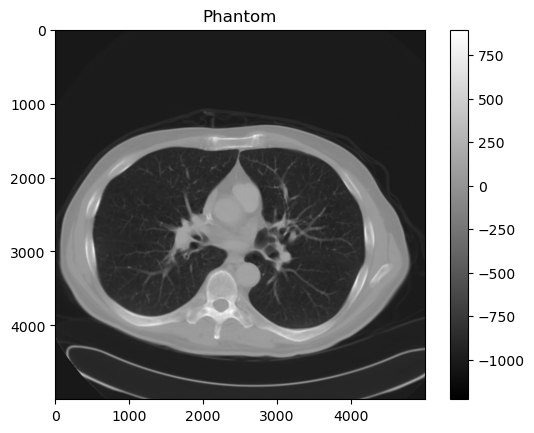

In [44]:
N_side = 5000 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]

from skimage import io
import scipy
# Specify the path to your TIFF image file
image_path = "true.tiff"
# Open the TIFF image
img = io.imread(image_path)
phantom = scipy.ndimage.zoom(img, N_side/np.array(img.shape))
print(phantom.shape)



# phantom = np.zeros((N_side, N_side))
# phantom[N_side//2 - 1000:N_side//2 + 1000, N_side//2 - 1000:N_side//2 + 1000] = 1
arg_shape = phantom.shape

plt.figure('Phantom')
plt.imshow(phantom, cmap='gray')
plt.title('Phantom')
plt.colorbar()
plt.show()

N_angle  = 300 #30 20 old
N_offset = 100 #50

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.1  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

### Definition of the operators 
> X-ray transform with splines-basis functions of degree 0 (pixels), 1, or 2.

\begin{equation}
    \mathcal{P}_{\theta}\{f\}(z) = \int_{\mathbb{R}} f(t \theta+{P}_{\theta^{\perp}}^{T}z)\ \mathrm{d} t,
\end{equation}

In [45]:
op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

sample normal
norm diff splines :  4312184.999111392
norm diff pixels  :  3422478.3306891588
Oversampled
norm diff splines :  21057050.015637867
norm diff pixels  :  23160936.16042965


ValueError: operands could not be broadcast together with shapes (10000,10000) (5000,5000) 

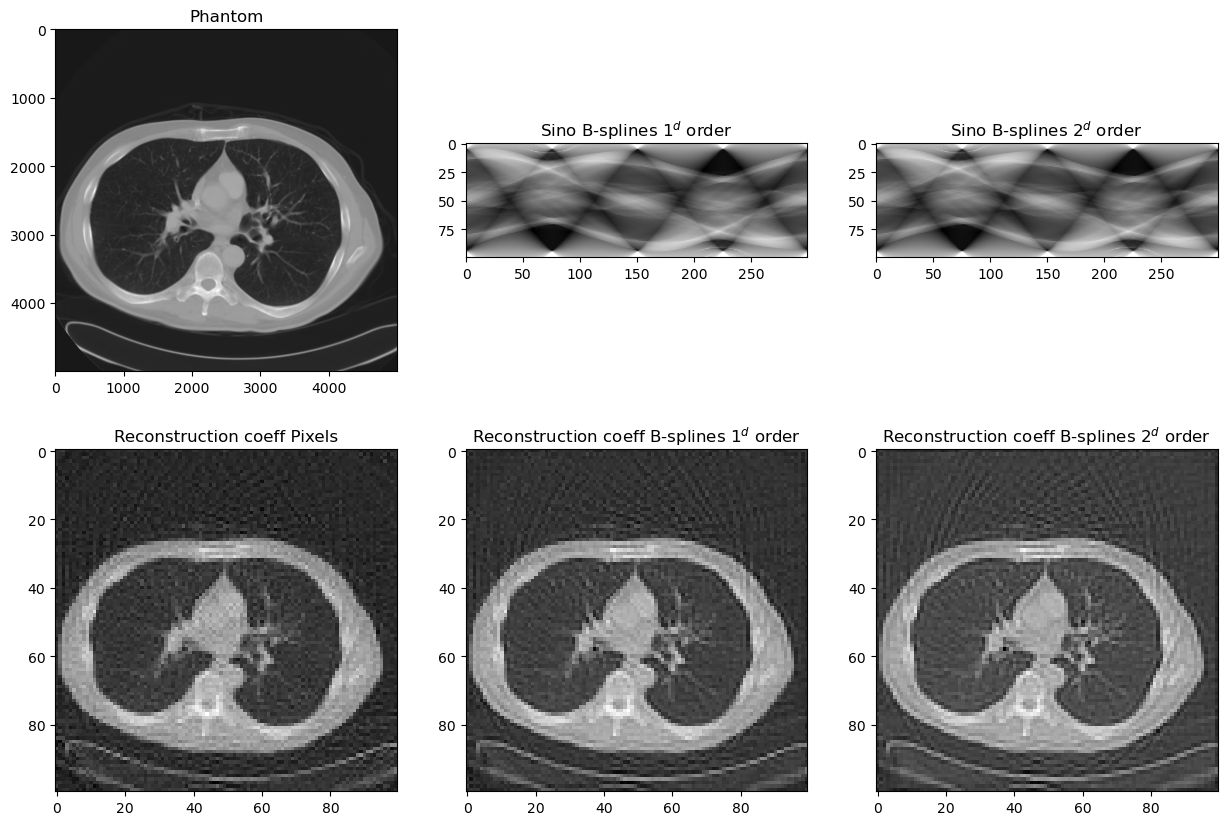

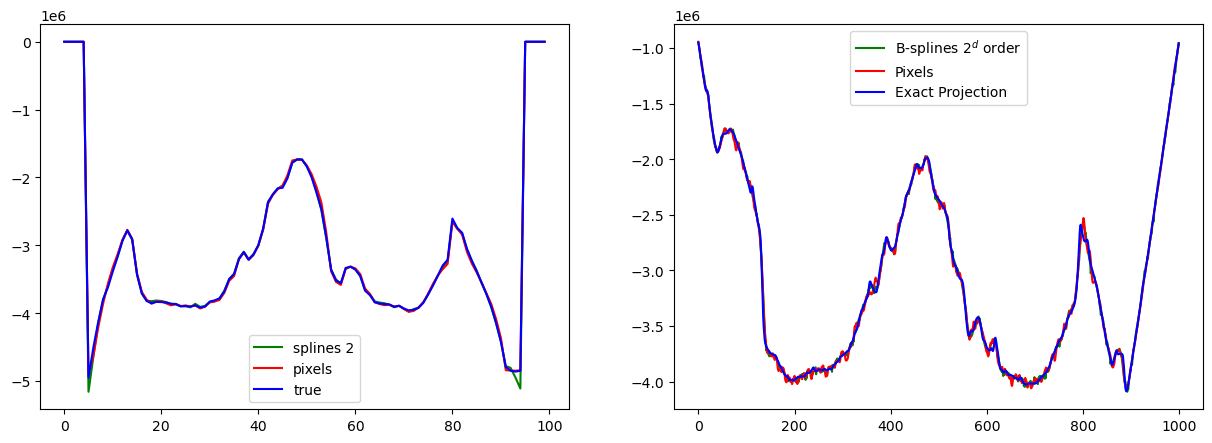

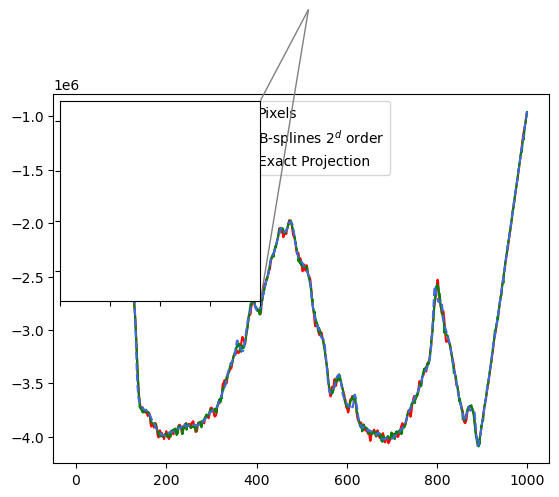

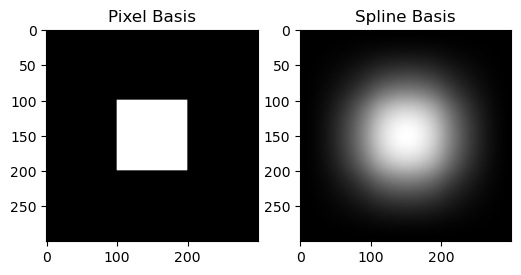

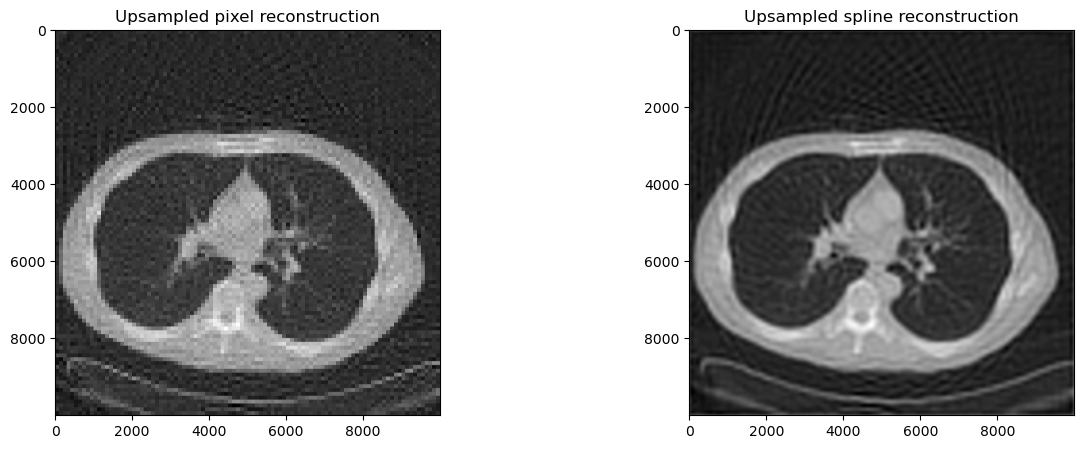

In [46]:
N_side = 5000 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]


# phantom = np.zeros((N_side, N_side))
# phantom[N_side//2 - 1000:N_side//2 + 1000, N_side//2 - 1000:N_side//2 + 1000] = 1
arg_shape = phantom.shape

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.1  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)


#N_angle  = 50
N_offset_true = 1000
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.1  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset_true, endpoint=True)

n_spec_true  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset_true, 2))  # (N_angle, N_offset_true, 2)
t_spec_true  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset_true, 1)  # (N_angle, N_offset_true, 2)
t_spec_true += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset_true,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec_true  = cp.array(t_spec_true)
n_spec_true  = cp.array(n_spec_true)

op_true = pxr.XRayTransform.init( #for reconstruction
    arg_shape=arg_shape,
    t_spec=t_spec_true.reshape(-1,2), 
    n_spec=n_spec_true.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

stop_crit = pxst.MaxIter(30) #30 before

oversampling = N_offset
op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)

#add noise
#y_data = np.array(y_data.get()) + 20*np.random.random(y_data.shape)
#y_data = cp.array(y_data)
recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_splines_1.T, cmap='gray')
axes[0, 1].set_title('Sino B-splines $1^d$ order')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()


#N_angle  = 50
N_offset = 1000 
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.1  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

ax.plot(fwd_splines[9], label='B-splines $2^d$ order', c='green')
axins.plot(fwd_splines[9], label='B-splines $2^d$ order', c='green')

ax.plot(true_proj[9], label='Exact Projection', c='royalblue', linestyle = '--')
axins.plot(true_proj[9], label='Exact Projection', c='royalblue', linestyle = '--')


x1, x2, y1, y2 = 505-10, 505+10, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

# Upsampling to approach continuum

mini_im = np.zeros((300,300))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[100:200, 100:200] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#plt.figure('pix upsampling')
#plt.imshow(mini_im_pix, cmap='gray')
ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[100:200, 100:200], mode='same')/100**2
mini_im_spline = spconv(mini_im_spline, mini_im_pix[100:200, 100:200], mode='same')/100**2
#plt.figure()
#plt.imshow(mini_im_spline)
ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((10200,10200))
for i in range(100):
    for j in range(100):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((10200,10200))
for i in range(100):
    for j in range(100):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('upsampled pix')
#plt.imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].set_title('Upsampled pixel reconstruction')
#plt.figure('upsampled spline')
#plt.imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[1].imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[1].set_title('Upsampled spline reconstruction')

#plt.figure('diff pix')
#plt.imshow(full_im_pix[100:-100, 100:-100] - phantom.get(), cmap='gray')
#plt.figure('diff splines')
#plt.imshow(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get(), cmap='gray')


print(np.linalg.norm(full_im_pix[100:-100, 100:-100] - phantom.get()))
print(np.linalg.norm(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get()))
plt.show()

One non zero coefficient


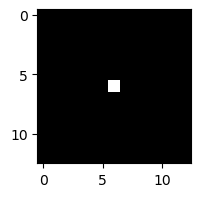

In [31]:
N_side = 13 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]
phantom = np.zeros((N_side, N_side))

phantom[ N_side//2, N_side//2 ] = 1

arg_shape = phantom.shape

plt.figure(figsize=(2,2))
plt.imshow(phantom, cmap='gray')

N_angle  = 1 
N_offset = 5000 

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.1  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
print('One non zero coefficient')

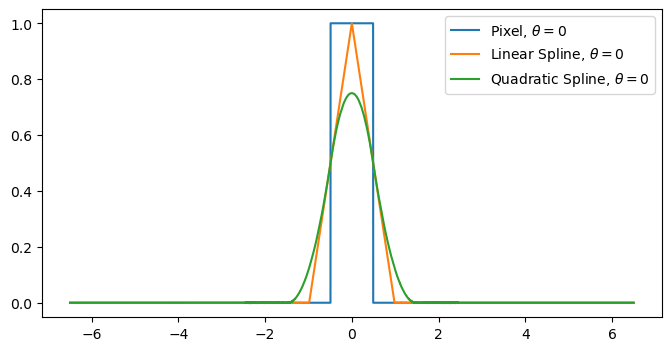

In [32]:
fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

plt.figure('X-ray spline Projection', figsize=(8,4))
for k in range(len(angles)):
    num = k
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$')

    plt.legend()


"plt.figure('X-ray Box-splines')\n\nfor k in range(len(angles)):\n    num = k\n    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')\n    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$', c='blue')\n    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$', c='red')\n\nplt.show()"

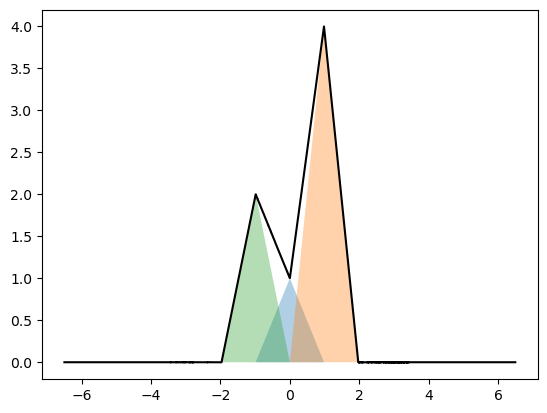

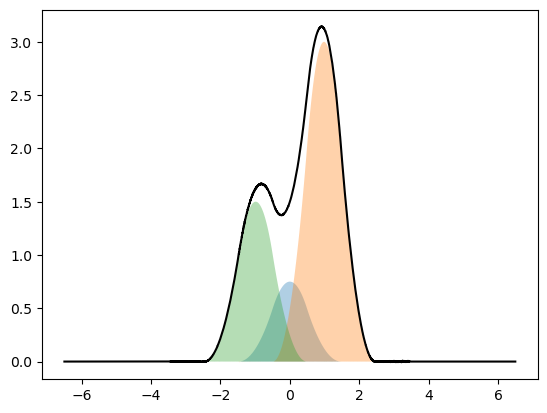

In [33]:
plt.figure('Spline construction : CPWL')
for k in range(len(angles)):
    num = k
    
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 0
    phantom[N_side//2,N_side//2+1] = 4
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    
    phantom[N_side//2,N_side//2+1] = 0
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 1
    phantom[N_side//2,N_side//2+1] = 4
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], color='k')

plt.figure('Spline construction : CPWQ')
for k in range(len(angles)):
    num = k
    
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 0
    phantom[N_side//2,N_side//2-1] = 0
    phantom[N_side//2,N_side//2+1] = 4
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    
    phantom[N_side//2,N_side//2+1] = 0
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 1
    phantom[N_side//2,N_side//2+1] = 4
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], color='k')
    
#phantom[N_side//2,N_side//2] = 0 test ici pour git
phantom[N_side//2,N_side//2+1] = 0
phantom[N_side//2,N_side//2-1] = 0
fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

'''plt.figure('X-ray Box-splines')

for k in range(len(angles)):
    num = k
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$', c='blue')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$', c='red')

plt.show()'''